## Loan Default Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore') # To get rid of warning messages

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Update default background style of plots
sns.set_style(style = 'darkgrid')

In [2]:
# Let us import the files
df = pd.read_csv('Default.csv')

In [3]:
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.53,"44,361.63"
1,2,No,Yes,817.18,"12,106.13"
2,3,No,No,"1,073.55","31,767.14"
3,4,No,No,529.25,"35,704.49"
4,5,No,No,785.66,"38,463.50"


In [4]:
# Dropping index column

df.drop(columns = ['Unnamed: 0'], inplace = True)

df.head()

,default,student,balance,income
0,No,No,729.53,"44,361.63"
1,No,Yes,817.18,"12,106.13"
2,No,No,"1,073.55","31,767.14"
3,No,No,529.25,"35,704.49"
4,No,No,785.66,"38,463.50"


In [5]:
# Encoding categorical variables
encoding_dict = {'Yes': 1, 'No': 0}

In [6]:
# Encoding features

df['default'] = df['default'].map(encoding_dict)
df['student'] = df['student'].map(encoding_dict)

In [7]:
df.head()

,default,student,balance,income
0,0,0,729.53,"44,361.63"
1,0,1,817.18,"12,106.13"
2,0,0,"1,073.55","31,767.14"
3,0,0,529.25,"35,704.49"
4,0,0,785.66,"38,463.50"


In [8]:
# Percentage of defaulters and non-defaulters
df['default'].value_counts(normalize = True)

0   0.97
1   0.03
Name: default, dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  int64  
 1   student  10000 non-null  int64  
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


### Linear Discriminant Analysis

In [10]:
balance = df.balance.values.reshape(len(df['balance']), 1)
default = df.default.values.reshape(len(df['default']), 1)
student = df.student.values.reshape(len(df['student']), 1)
income = df.income.values.reshape(len(df['income']), 1)

features = ['balance', 'student', 'income']

In [11]:
# Fitting LDA and QDA models using on balance as a feature

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(balance, df['default'])
lda_error_rate_bal = (1 - lda.score(balance, default))*100

qda.fit(balance, df['default'])
qda_error_rate_bal = (1 - qda.score(balance, default))*100

print("LDA error rate while using only balance as a feature is {}% ".format(np.round(lda_error_rate_bal, 2)))
print("QDA error rate while using only balance as a feature is {}%".format(np.round(qda_error_rate_bal, 2)))

LDA error rate while using only balance as a feature is 2.81% 
QDA error rate while using only balance as a feature is 2.74%


In [12]:
# Fitting LDA and QDA models with all features
lda.fit(df[features], df['default'])
new_lda_error_rate = (1 - lda.score(df[features], df['default']))*100

qda.fit(df[features], df['default'])
new_qda_error_rate = (1 - qda.score(df[features], df['default']))*100

print("LDA error rate using all the features is {}% ".format(np.round(new_lda_error_rate, 2)))
print("QDA error rate using all the features is {}%".format(np.round(new_qda_error_rate, 2)))

LDA error rate using all the features is 2.76% 
QDA error rate using all the features is 2.7%


### Logistic Regression

In [13]:
lr = LogisticRegression(penalty = 'none', max_iter = 100)

lr.fit(balance, df['default'])

lr_error_rate = (1 - lr.score(balance, df['default']))*100

print("Logistic Regression error rate using balance feature is {}% ".format(np.round(lr_error_rate, 2)))

Logistic Regression error rate using balance feature is 2.75% 


In [14]:
lr.get_params

<bound method BaseEstimator.get_params of LogisticRegression(penalty='none')>

In [15]:
lrm = LogisticRegression(penalty = 'none')

lrm.fit(df[features], df['default'])

lr_error_rate = (1 - lrm.score(df[features], df['default']))*100

lrm_r = LogisticRegression(penalty = 'l1', solver = 'liblinear')

lrm_r.fit(df[features], df['default'])

lrm_r_error_rate = (1 - lrm_r.score(df[features], df['default']))*100

print("Logistic Regression error rate using all the features is {}% ".format(np.round(lr_error_rate, 2)))
print("Logistic Regression error rate using absolute value (Lasso) regularization is {}% ".format(np.round(lrm_r_error_rate, 2)))

Logistic Regression error rate using all the features is 3.28% 
Logistic Regression error rate using absolute value (Lasso) regularization is 2.69% 


### K-Nearest Neighbors (K-NN)

In [16]:
ss = StandardScaler()

In [17]:
# Determining K where error rate is the lowest
train_error = []
test_error = []
knn_many_split = {}
error_df_knn = pd.DataFrame()


for k in range(1,16):
    
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors = k)
    print(k)

    for i in range(100):
        x_train, x_test, y_train, y_test = train_test_split(df[features], df['default'], test_size = 0.20)

        # Let us scale the data. Notice the scaling done here.
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)
        
        # Fitting the K-NN model
        knn.fit(x_train, y_train)
        
        # Finding train and test errors
        train_error.append(1 - knn.score(x_train, y_train)) 
        test_error.append(1 - knn.score(x_test, y_test))
    
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista
    print(knn_many_split[k])

knn_many_split

1
[0.0, 0.04353000000000001]
2
[0.02189750000000001, 0.03283]
3
[0.02214499999999999, 0.03362999999999999]
4
[0.025034999999999988, 0.030344999999999997]
5
[0.02498874999999999, 0.03024000000000001]
6
[0.025581249999999996, 0.028529999999999993]
7
[0.025047499999999997, 0.028769999999999997]
8
[0.025406249999999995, 0.02891499999999999]
9
[0.025490000000000013, 0.028745000000000003]
10
[0.02578875000000001, 0.02869500000000001]
11
[0.025851250000000003, 0.02810999999999999]
12
[0.026320000000000027, 0.028050000000000002]
13
[0.025961249999999995, 0.02783999999999999]
14
[0.026456250000000008, 0.02778999999999998]
15
[0.026180000000000023, 0.028144999999999993]


{1: [0.0, 0.04353000000000001],
 2: [0.02189750000000001, 0.03283],
 3: [0.02214499999999999, 0.03362999999999999],
 4: [0.025034999999999988, 0.030344999999999997],
 5: [0.02498874999999999, 0.03024000000000001],
 6: [0.025581249999999996, 0.028529999999999993],
 7: [0.025047499999999997, 0.028769999999999997],
 8: [0.025406249999999995, 0.02891499999999999],
 9: [0.025490000000000013, 0.028745000000000003],
 10: [0.02578875000000001, 0.02869500000000001],
 11: [0.025851250000000003, 0.02810999999999999],
 12: [0.026320000000000027, 0.028050000000000002],
 13: [0.025961249999999995, 0.02783999999999999],
 14: [0.026456250000000008, 0.02778999999999998],
 15: [0.026180000000000023, 0.028144999999999993]}

In [18]:
# Extracting k, the train error, and the test error in separate lists
kl = []
vl = []
v2 = []

for k, v in knn_many_split.items():
    
    kl.append(k)
    
    vl.append(knn_many_split[k][1])
    
    v2.append(knn_many_split[k][0])

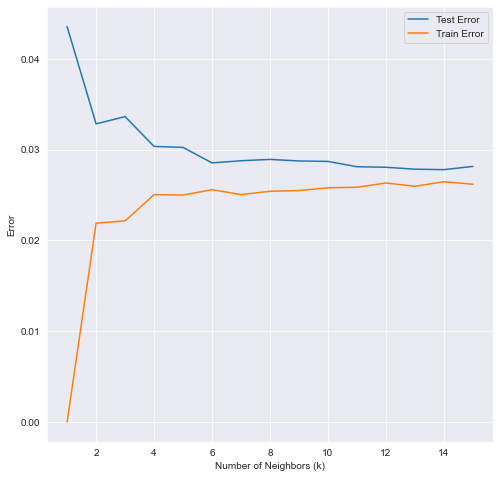

In [19]:
# Plotting k vs train and test error
plt.figure(figsize = (8, 8))

plt.xlabel("Number of Neighbors (k)")

plt.ylabel("Error")

plt.plot(kl, vl, label = 'Test Error')

plt.plot(kl, v2, label = 'Train Error')

plt.legend()

plt.show()